# LSA_analysis

Chris Siviy and Taira Miyatake

In [22]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn import discriminant_analysis
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
import time
import matplotlib.pyplot as plt
import warnings
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import time
import os
from scipy.stats import spearmanr
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Parameters for the whole notebook
small_fig_size = [6.5, 6.5]  # Small figure size, [w h], inches

In [6]:
# Import data
filename = 'training_set_rel3.tsv'
df = pd.read_csv(filename, encoding='iso-8859-1', delimiter='\t')  ## error with utf-8 encoding
print 'Data shape: ', df.shape

# List of dataframes. Each dataframe contains data for each essay set.
dfs = []
dfs = [df[df['essay_set']==i+1] for i in range(8)]

# Turn into vector of features
vectorizers = [TfidfVectorizer() for i in range(8)]
# vectorizers = [CountVectorizer() for i in range(8)]
corpuses = [dfs[i]['essay'].values for i in range(8)]
word_mats = [vectorizers[i].fit_transform(corpuses[i]) for i in range(8)]

# Save a copy of all the word matrices
word_mats = np.array(word_mats).copy()

responses_vars = [['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 1
                  ['rater1_domain1', 'rater2_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2', 'domain2_score'], ## essay set 2
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 3
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 4
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 5
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 6
                  ['rater1_domain1', 'rater2_domain1','domain1_score'], ## essay set 7
                  ['rater1_domain1', 'rater2_domain1','domain1_score'] ## essay set 8
                ]
Y = [dfs[i][responses_vars[i]] for i in range(8)]
#Y = [dfs[i]['domain1_score'] for i in range(8)]

# Normalize the score to 0.0 - 1.0 scale.
for i in range(len(Y)):
    max = Y[i]['domain1_score'].max()
    min = Y[i]['domain1_score'].min()
#     max = Y[i].max()
#     min = Y[i].min()
    a = 1.0/(max-min)
    b = float(-min)/(max-min)
    Y[i]['domain1_score'] *= a
    Y[i]['domain1_score'] += b

Data shape:  (12976, 28)


In [9]:
# Load in the prompt data

def loadPromptData(file_name, vectorizer):
    # LOADPROMPTDATA load in data from the prompt and vectorize
    #
    # INPUTS
    #     file_name: File with the prompt text
    #    vectorizer: Sklearn vectorizer
    #
    #
    
#     print file_name
    
#     # Load
#     text_data = np.loadtxt(file_name, 
#                            dtype='str',
#                            delimiter=np.NAN).reshape(-1)

    
#     text_data = np.genfromtxt(file_name, dtype='str', ).reshape(-1)
    import codecs
    fid = codecs.open(file_name, 'r', encoding='iso-8859-1')
    
    text_data = fid.read()
    text_data.replace('\n', '')
    
    # convert to numpy
    text_data = np.array(text_data).reshape(-1)
    
#     print text_data
    
    fid.close()
    
    # Vectorize
    prompt_vec = vectorizer.transform(text_data)
    
#     print prompt_vec.shape
    
    return prompt_vec
    

prompt_vecs = np.array([])

# Load in and vectorize the prompt data
for i in range(len(word_mats)):
    
    prompt_vec_tmp = loadPromptData('essay_prompt_%d.txt'%(i+1),
                                    vectorizers[i])
    
    prompt_vecs = np.append(prompt_vecs, prompt_vec_tmp)
    
   

In [10]:
def reduceDims(essay_matrix, prompt_vector, n_components):
    # REDUCEDIMS Conduct LSA on a document's word matrix
    #
    # INPUTS
    #     essay_matrix: bag-of-words matrix for the essay set
    #    prompt_vector: Vectorized essay prompt
    #     n_components: Maximum number of elements to use after
    #                   dimensionality reduction
    #
    #
    
    # Initialize LSA object
    lsa_mdl = TruncatedSVD(n_components=n_components)
    
    # Fit
    lsa_results = lsa_mdl.fit_transform(essay_matrix)
    
    # Transform the prompt vector too
    prompt_results = lsa_mdl.transform(prompt_vector)
    
    cos_sim = np.sum(np.multiply(prompt_results, lsa_results), axis=1) / \
              (np.linalg.norm(prompt_results, axis=1) * np.linalg.norm(lsa_results, axis=1))
        
    
    return lsa_results, cos_sim, lsa_mdl.explained_variance_ratio_
    
# # Run through all the essay sets and perform dimensionality reduction
# cos_sim = np.array([])
# # X = np.array([])
# X = np.zeros(word_mats.shape)
# for i in range(len(word_mats)):
    
#     X_tmp, cos_sim_tmp = reduceDims(word_mats[i],
#                                     prompt_vecs[i],
#                                     5)
    
#     X = np.append(X, X_tmp)
#     cos_sim_tmp = np.append(cos_sim, cos_sim_tmp)
        



In [11]:
def getFeatures(essay_matrix, prompt_vector, n_components, meta_features):
    # GETFEATURES Get all the features for a given essay set and concatenate them together
    #
    # INPUT
    #    essay_matrix: Bag-of-words vectors for all essays in the set
    #   prompt_vector: Bag-of-words vector for the prompt
    #    n_components: Number of features to use in LSA dimensionality reduction
    #   meta_features: Pre-calculated meta-features. Should be a dense array
    #
    #
    #
    
    
    # Reduce dimensions
    essay_matrix_reduced, cos_sim, exp_var = reduceDims(essay_matrix,
                                               prompt_vector,
                                               n_components)
    
    
    # Concatenate
    X = np.hstack((essay_matrix_reduced,
                   cos_sim.reshape(-1,1),
                   meta_features))
    
    return X, exp_var
    

# This is an example of how to run for essay set 1. The meta-features array is just filler for now 
#getFeatures(word_mats[0], prompt_vecs[0], 5, np.ones(word_mats[0][:,0].shape))

In [12]:
## extract_meta_data()
# function to extract 4 meta data
# input: df (e.g. df[0] for essayset 1), word_mat (e.g. word_mats[0] for essayset 1)
# output: meta_output : n x 4 np array containing meta data

def extract_meta_data(df, word_mat):
    # Number of unique words
    unique_words = np.array(word_mat.todense()!=0).sum(axis=1)
    unique_words = unique_words.reshape((unique_words.shape[0], 1)) #reshape for concatenating
    # word counts, word lengths and sentence lengths
    # initialize list
    word_lengths = []
    sent_lengths = []
    word_counts = []
    texts = df['essay']
    for text in texts:
        text = text.replace('/', ' ')
        sent_tokenize_list = sent_tokenize(text)
        text = text.replace('.', '')
        text = text.replace(',', '')
        text = text.replace('?', '')
        text = text.replace('@', '')
        text = text.replace('!', '')
        word_tokenize_list = word_tokenize(text)
        word_counts.append(len(word_tokenize_list))
        word_lengths.append(np.array([len(s) for s in word_tokenize_list]).mean())
        sent_lengths.append(np.mean([len(word_tokenize(sent_tokenize_list[k])) for k in range(len(sent_tokenize_list))]))
    word_counts = np.array(word_counts).reshape((len(word_counts), 1)) #reshape for concatenating
    word_lengths = np.array(word_lengths).reshape((len(word_lengths), 1)) #reshape for concatenating
    sent_lengths = np.array(sent_lengths).reshape((len(sent_lengths), 1)) #reshape for concatenating
    
    # output is n x 4 numpy array
    meta_output = np.concatenate((word_counts, unique_words, word_lengths, sent_lengths), axis=1)
    
    return meta_output


In [14]:
metas = []
for i in range(8):
     metas.append(extract_meta_data(dfs[i], word_mats[i]))

In [15]:
# Fit a new multiple linear regression model on each essay set
def fitAndScoreModel(mdl, word_matrix, Y, graph=0, ax=0):
    # FITANDSCOREMODEL Fit and score a model for the current datafram
    #
    # INPUTS
    #             mdl: Model object
    #     word_matrix: Bag-of-words matrix. Dim 0 is essays and dim 1 is words
    #               Y: Scores corresponding to this essay set
    # OUTPUTS
    #             score: Score of testing data
        
    # Split into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(word_matrix, Y, test_size=0.1)
    
    # Initialize and fit the model
    mdl.fit(x_train, y_train)
    
    # Score the model and print
    pred_score = mdl.predict(x_test)
    
    # If prediction is out of bounds, fix it to 0/1.
    pred_score = np.array([0.0 if i < 0 else i for i in pred_score])
    pred_score = np.array([1.0 if i > 1 else i for i in pred_score])
    
    score = mdl.score(x_test, y_test)
    
    if graph==1:
        ax.scatter(pred_score, y_test)

        # Cosmetic
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('%d %d; %d %d; %5.3f'%(pred_score.min(), pred_score.max(), y_test.min(), y_test.max(),
                                            score))
        

        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        ax.grid()
    return mdl.score(x_test, y_test)

### Dimension selection for dimension reduction in LSA
In order to find the optimal dimension for LSA, we plotted Score vs Dimension (d) for d ranging from 1-800.

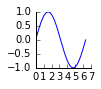

In [17]:
small_fig_size=[1, 1]
def saveFigure(file_name, fig, fig_size=small_fig_size, save_dir='Results'):
    # Save a figure and make it look nice
    #
    #
    
    # Make the save directory, if necessary
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    
    # Set the figure size
    fig.set_size_inches(fig_size[0], fig_size[1])
    
    # Build up the file name
    file_name = os.path.join(save_dir, file_name)
    
    # Get rid of grid and box
    for ax in fig.axes:
        
        ax.grid(b=False)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        
    
    # Save as a variety of file types
    #fig.tight_layout()
    plt.show()
    plt.draw()
    
    fig.savefig(file_name+'.png',
                dpi=600)
    
    fig.savefig(file_name+'.pdf')
    
    
    
    

# Test out the plotting function
test_x = np.linspace(0, 2 * np.pi, 1.e3)
test_y = np.sin(test_x)

fig, ax = plt.subplots(1, 1)
ax.plot(test_x, test_y)

saveFigure('testFile', fig=fig)

Processing essay-set 1 ...
0.00846240867185


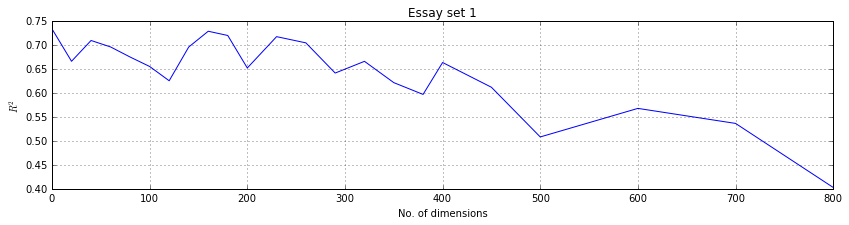

Processing essay-set 2 ...
0.220079696044


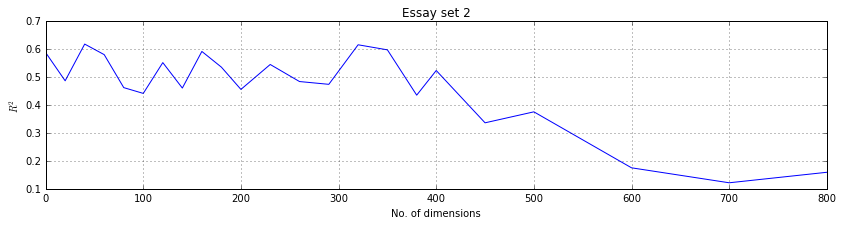

Processing essay-set 3 ...
0.487662709251


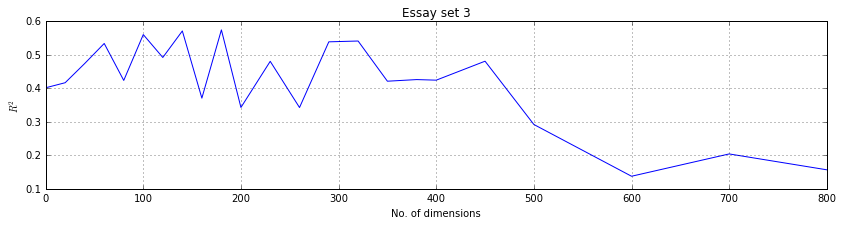

Processing essay-set 4 ...
0.344154001966


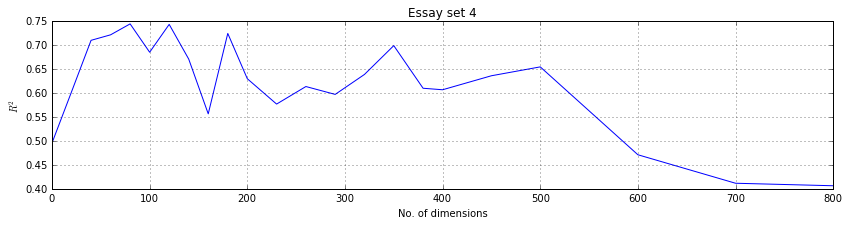

Processing essay-set 5 ...
0.340959526145


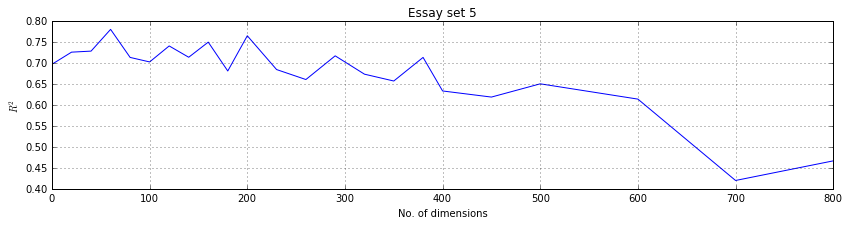

Processing essay-set 6 ...
0.346744051009


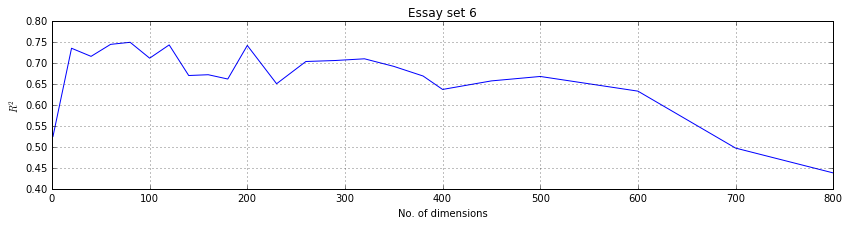

Processing essay-set 7 ...
0.26554490358


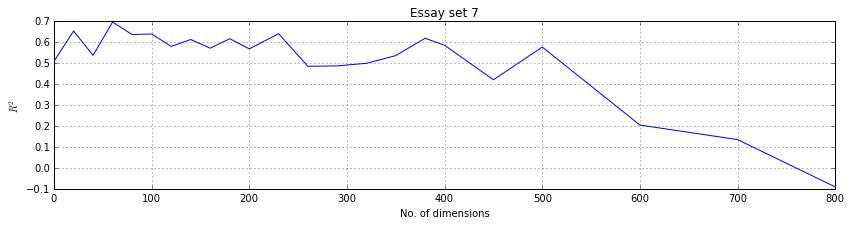

Processing essay-set 8 ...
0.336337926033


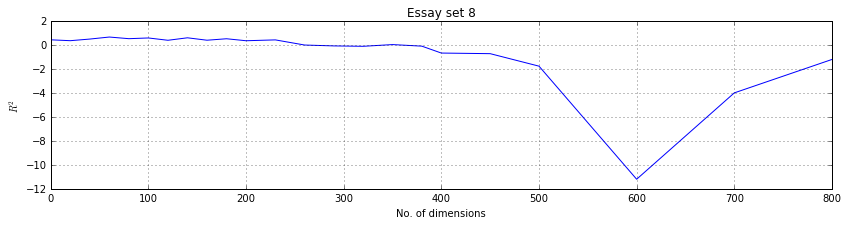

[1, 40, 180, 80, 60, 80, 60, 60]


In [21]:
opt_d_list = []
score_list_list = []
exp_var_list = []
d_list = [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 230, 260, 290, 320, 350, 380, 400, 450, 500, 600, 700, 800]
#d_list = [1, 20, 40, 60]

for i in range(8):
    
    fig = plt.figure(figsize=(14, 3))
    print 'Processing essay-set %d ...'%(i+1)
    
    max_d = 0
    max_score = 0.0
    ax = fig.add_subplot(1, 1, 1)
    score_list = []
    flag = 0
    
    # Run through all the possible d's
    for d in d_list:
        X, exp_var = getFeatures(word_mats[i], prompt_vecs[i], d, metas[i])
        score = fitAndScoreModel(linear_model.LinearRegression(), X, Y[i]['domain1_score'].values)
        score_list.append(score)
        if score > max_score:
            max_score = score
            max_d = d
            explained = np.sum(exp_var[:max_d])

    score_list_list.append(score_list)
    opt_d_list.append(max_d)
    ax.plot(d_list, score_list)
    exp_var_list.append(explained)
    print explained

    # Set titles
    ax.set_title('Essay set %d'%(i+1))
    ax.set_xlabel('No. of dimensions')
    ax.set_ylabel('$R^2$')
    
    # Cosmetic
#     ax.spines()
    ax.grid()
#     plt.tight_layout()
    plt.show()
    
    # Save the figure
    saveFigure('r2_vs_d_set_%d'%(i+1), fig)
    
    
print opt_d_list
plt.show()

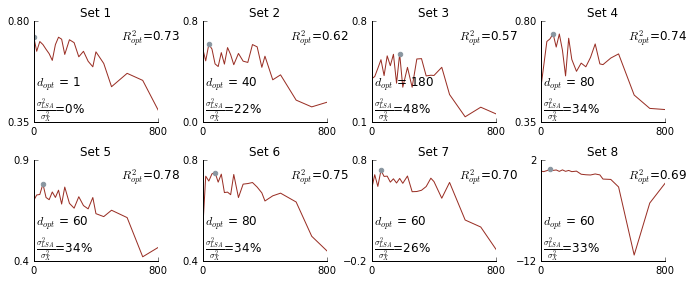

In [23]:
fig = plt.figure(figsize=(10.5, 4.0))
for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(d_list, score_list_list[i], color='#992E24', zorder=0)
    label = '$d_{opt}$ = %d\n$\\frac{\sigma^2_{LSA}}{\sigma^2_{X}}$=%d%% '%(opt_d_list[i], 100.*exp_var_list[i])
    #label = '$\\frac{\sigma^2_{LSA}}{\sigma^2_{X}}$=%d%% '%(100.*exp_var_list[i])
    handle = ax.scatter(opt_d_list[i], np.max(score_list_list[i]), label=label, color='#8996A0', zorder=1)
    
    title = 'Set %d'%(i+1)
    ax.set_title(title)
    ax.set_xticks([0, 800])
    ax.set_yticks([ax.get_yticks()[0], ax.get_yticks()[-1]])
    ax.set_xlim([0, 800])
    #ax.plot([0, opt_d_list[i], opt_d_list[i]], [np.max(score_list_list[i]), np.max(score_list_list[i]), 0])
    #print type(handle)
    #ax.legend((handle,), (label,))
    fontdict = {'fontsize':12}
    ax.text(0.02, 0.05, label, transform=ax.transAxes, fontdict=fontdict)
    ax.text(0.7, 0.8, '$R^2_{opt}$=%.2f'%(np.max(score_list_list[i])), transform=ax.transAxes, fontdict=fontdict)
    ax.grid()
    
    # Save the figure
plt.tight_layout()
saveFigure('d_tuning', fig=fig, fig_size=[9.5, 4.0])
plt.show()

### Lasso
For optimal dimension chosen above, we will further regularize the input dimension by Lasso. To reduce variance, we will use LassoCV.

In [73]:
# Create input matrix depending on optimized PCA dimension found above
X = []
for i in range(8):
    X.append(getFeatures(word_mats[i], prompt_vecs[i], opt_d_list[i], metas[i]))

Essay-set 1:
  Chosen regularization parameter: 1e-08
  Number of non-zero coeffs: 5 / 6
  Score(R2): 0.717 



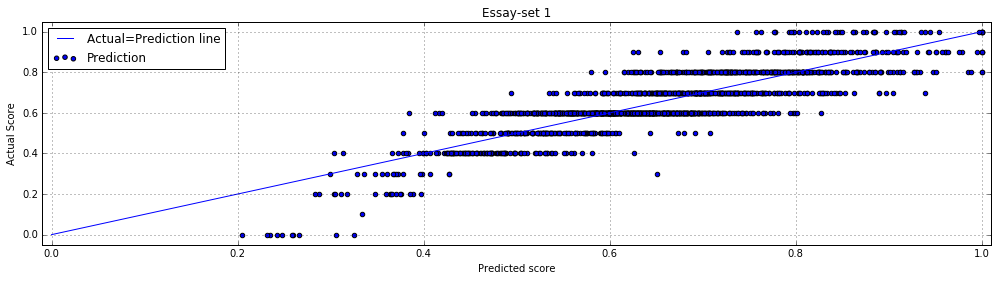

Essay-set 2:
  Chosen regularization parameter: 0.0001
  Number of non-zero coeffs: 34 / 45
  Score(R2): 0.586 



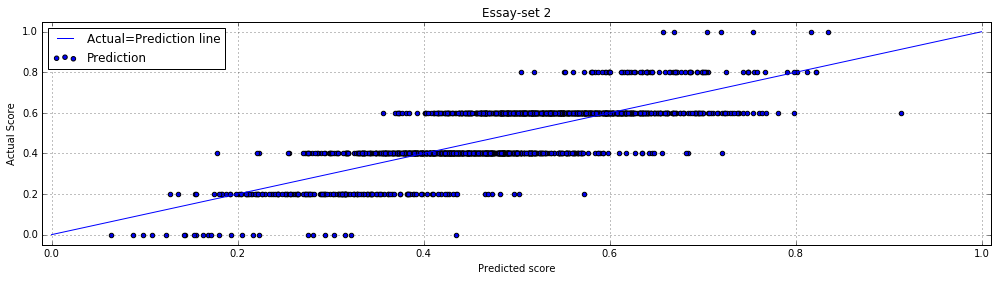

Essay-set 3:
  Chosen regularization parameter: 0.001
  Number of non-zero coeffs: 11 / 185
  Score(R2): 0.533 



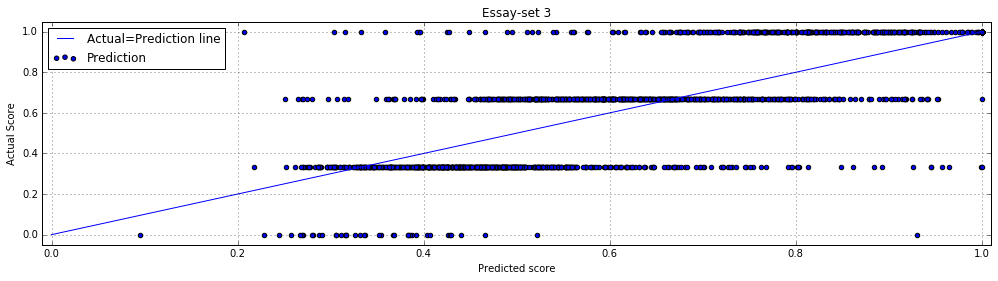

Essay-set 4:
  Chosen regularization parameter: 0.0001
  Number of non-zero coeffs: 62 / 85
  Score(R2): 0.724 



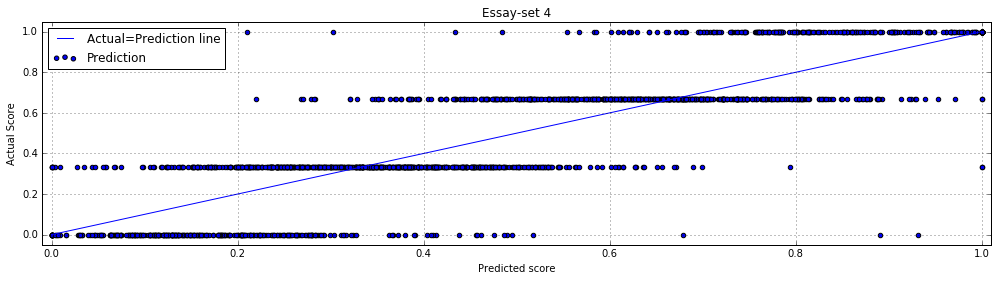

Essay-set 5:
  Chosen regularization parameter: 0.0001
  Number of non-zero coeffs: 51 / 65
  Score(R2): 0.754 



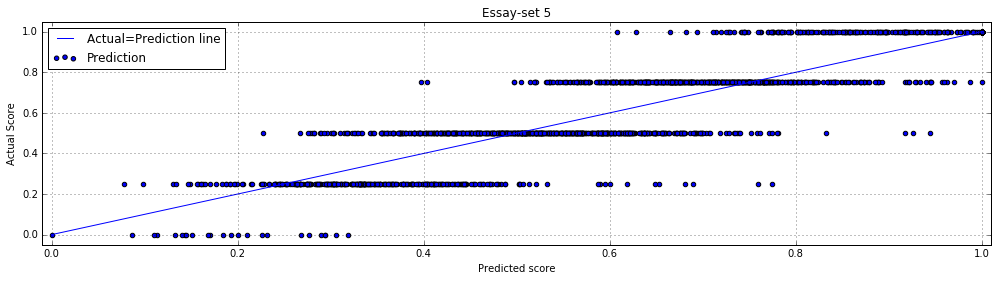

Essay-set 6:
  Chosen regularization parameter: 0.0001
  Number of non-zero coeffs: 62 / 85
  Score(R2): 0.743 



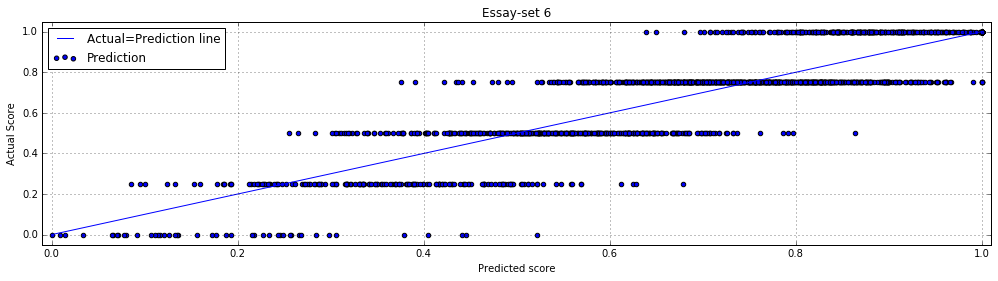

Essay-set 7:
  Chosen regularization parameter: 0.0001
  Number of non-zero coeffs: 51 / 65
  Score(R2): 0.663 



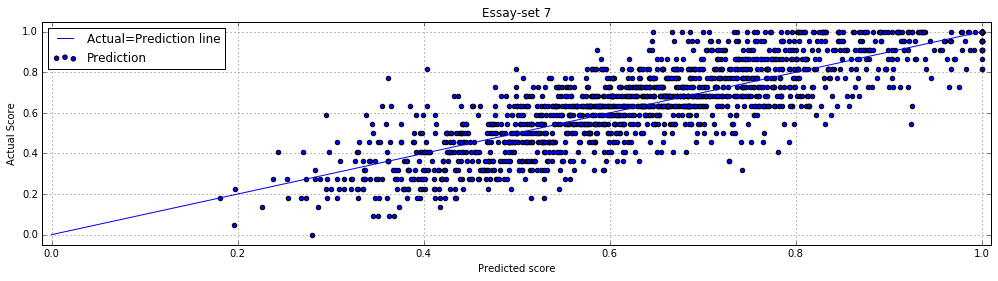

Essay-set 8:
  Chosen regularization parameter: 0.0001
  Number of non-zero coeffs: 46 / 65
  Score(R2): 0.583 



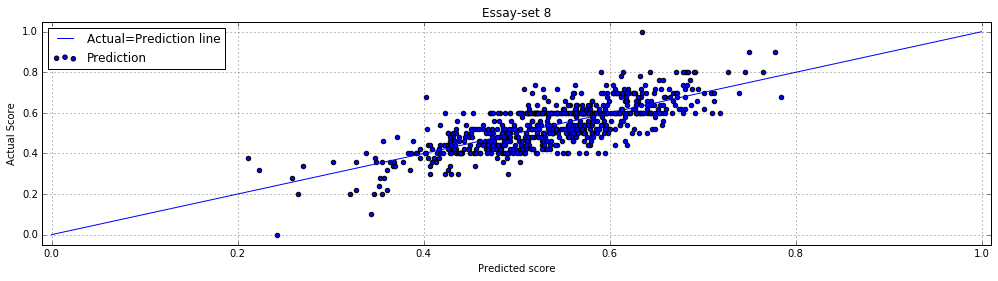

In [26]:
### Lasso
for i in range(8):
    fig = plt.figure(figsize=(17, 4))
    alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 1e2, 1e3]
    lasso_cv = linear_model.LassoCV(alphas=alphas, cv=5)
    y = Y[i]['domain1_score'].values
    lasso_cv.fit(X[i], y)
    y_pred = lasso_cv.predict(X[i])
    # Prediction is between 0.0 - 1.0
    y_pred[y_pred > 1.0] = 1.0
    y_pred[y_pred < 0.0] = 0.0
    
    # Calculate score (R2)
    SST = sum(np.power(y - np.mean(y), 2))
    SSR = sum(np.power((y - y_pred), 2))
    r2 = 1 - SSR/SST
    
    # Plotting
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(y_pred, Y[i]['domain1_score'], label='Prediction')
    ax.plot([0, 1],[0, 1], label='Actual=Prediction line')
    ax.set_title('Essay-set %d'%(i+1))
    ax.set_xlabel('Predicted score')
    ax.set_ylabel('Actual Score')
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([-0.01, 1.01])
    ax.grid()
    ax.legend(loc='best')
    
    # Printing
    print 'Essay-set %d:'%(i+1)
    print '  Chosen regularization parameter:', lasso_cv.alpha_
    print '  Number of non-zero coeffs:', len(lasso_cv.coef_.nonzero()[0]), '/', opt_d_list[i]+5
    print '  Score(R2):', round(r2, 3),'\n'
    plt.show()

- Dimens

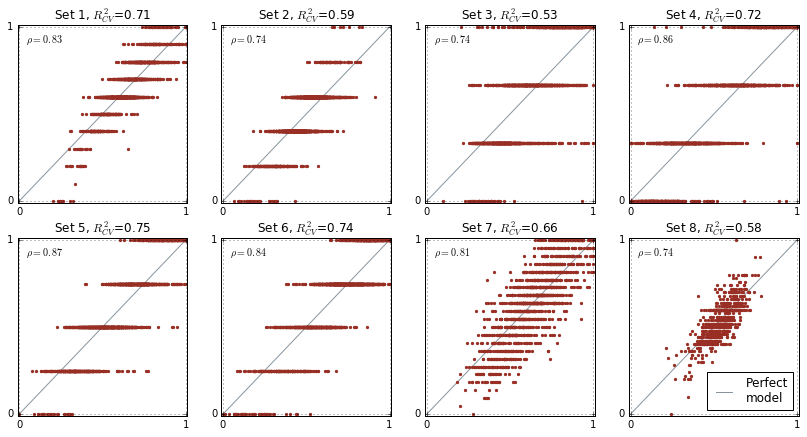

In [25]:
# Create input matrix depending on optimized PCA dimension found above
X = []
for i in range(8):
    X.append(getFeatures(word_mats[i], prompt_vecs[i], opt_d_list[i], metas[i])[0])
    
fig = plt.figure(figsize=(14, 7))
### Lasso
for i in range(8):
    alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 1e2, 1e3]
    lasso_cv = linear_model.LassoCV(alphas=alphas, cv=5)
    y = Y[i]['domain1_score'].values
    lasso_cv.fit(X[i], y)
    y_pred = lasso_cv.predict(X[i])
    # Prediction is between 0.0 - 1.0
    y_pred[y_pred > 1.0] = 1.0
    y_pred[y_pred < 0.0] = 0.0
    
    # Calculate score (R2)
    SST = sum(np.power(y - np.mean(y), 2))
    SSR = sum(np.power((y - y_pred), 2))
    r2 = 1 - SSR/SST
    r2 = lasso_cv.score(X[i], y)
    
    rho, p = spearmanr(y_pred, y)
    
    # Plotting
    ax = fig.add_subplot(2, 4, i+1)
    ax.scatter(y_pred, Y[i]['domain1_score'], color='#992E24', label='Prediction', zorder=1, marker='.')
    handle = ax.plot([0, 1],[0, 1], color='#8996A0', label='Perfect\nmodel', zorder=0)
    title = 'Set %d, $R^2_{CV}$=%3.2f'%((i+1), r2)
    ax.set_title(title)
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlim([-0.01, 1.01])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.grid()
    text = '$\\rho=%.2f$'%rho
    ax.text(0.05, 0.9, text, transform=ax.transAxes)
    if i==7:
        ax.legend(handles=handle, loc='lower right')
    
plt.show()
saveFigure('final', fig_size=[9.5, 5.0], fig=fig)